In [2]:
import os
import requests

def download_file(url, dest_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()  # ensure we notice bad responses
    with open(dest_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"Downloaded file saved to {dest_path}")

# Replace this with your Bitly link
dataset_url = "https://bit.ly/4jnPqPB"

# Check if file already exists
dataset_path = "mushroom_dataset.csv"  # change the filename as needed
if not os.path.exists(dataset_path):
    user_input = input("Dataset not found. Would you like to download it? (y/n): ")
    if user_input.lower() == 'y':
        download_file(dataset_url, dataset_path)
    else:
        print("Dataset download skipped. Please ensure the dataset is in the correct path before running the code.")
else:
    print("Dataset already exists.")


Dataset already exists.


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the dataset (adjust the filename/path as needed)
df = pd.read_csv("mushroom_dataset.csv")

# Display first few rows to understand the structure
print("Original Data Sample:")
print(df.head())

# Initialize a dictionary to store label encoders for each column (in case you need to reverse the encoding later)
label_encoders = {}

# Apply Label Encoding to each column
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("\nLabel Encoded Data Sample:")
print(df.head())

Original Data Sample:
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p 

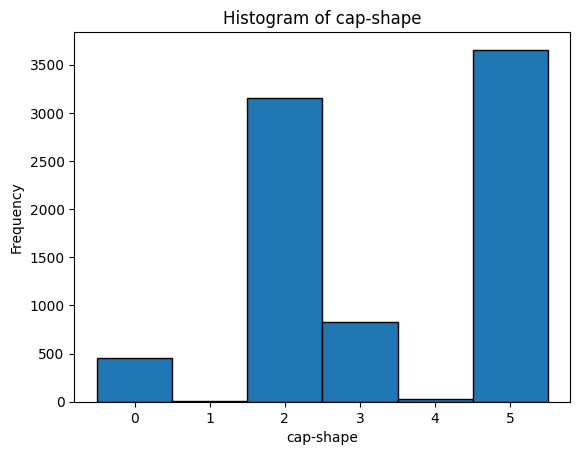

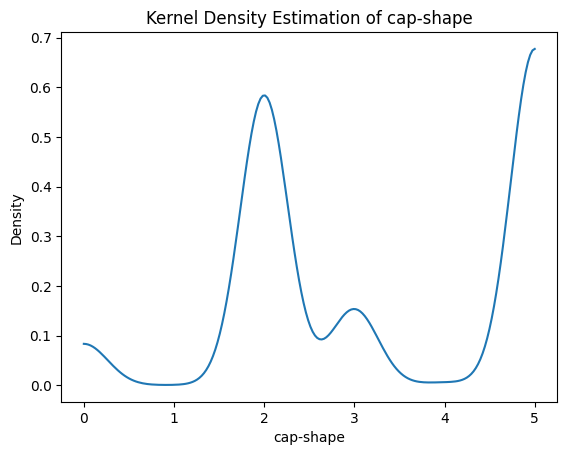

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde


# Select a feature to visualize. For example, "cap-shape".
feature = 'cap-shape'
data = df[feature]

# ---------------------------
# 1. Histogram Plot
# ---------------------------
plt.figure()
# Create bins centered on each integer value representing each category.
bins = np.arange(data.min(), data.max() + 2) - 0.5
plt.hist(data, bins=bins, edgecolor='black')
plt.title(f'Histogram of {feature}')
plt.xlabel(feature)
plt.ylabel('Frequency')
plt.xticks(np.arange(data.min(), data.max() + 1))
plt.show()

# ---------------------------
# 2. Kernel Density Estimation (KDE) Plot
# ---------------------------
# Note: KDE plots are generally used for continuous data. Since our feature is categorical,
# the KDE plot is only for exploratory purposes.
plt.figure()
# Calculate the density using Gaussian KDE
density = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 200)
plt.plot(x_vals, density(x_vals))
plt.title(f'Kernel Density Estimation of {feature}')
plt.xlabel(feature)
plt.ylabel('Density')
plt.show()


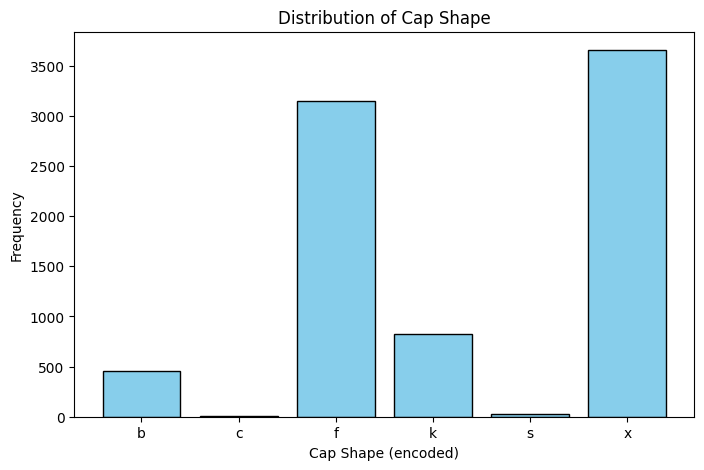

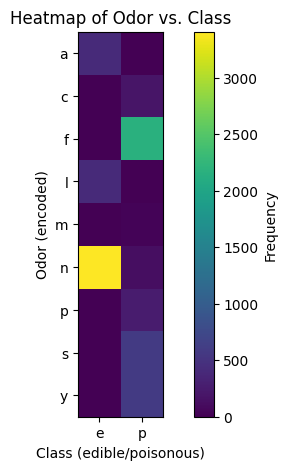

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset (update the path/filename as needed)
df = pd.read_csv("mushroom_dataset.csv")

# Example: Using 'cap-shape' as a feature to visualize its distribution.
# Assuming the CSV is already label encoded.
# If not, you can run LabelEncoder on 'cap-shape' as shown earlier.

# ---------------------------
# Bar Plot for 'cap-shape'
# ---------------------------
plt.figure(figsize=(8, 5))
# Count the occurrences of each category in 'cap-shape'
cap_shape_counts = df['cap-shape'].value_counts().sort_index()
plt.bar(cap_shape_counts.index, cap_shape_counts.values, color='skyblue', edgecolor='black')
plt.title('Distribution of Cap Shape')
plt.xlabel('Cap Shape (encoded)')
plt.ylabel('Frequency')
plt.xticks(cap_shape_counts.index)  # these are encoded values
plt.show()

# ---------------------------
# Heatmap for two categorical features: 'odor' and 'class'
# ---------------------------
# Create a cross-tabulation (contingency table) between 'odor' and 'class'
crosstab = pd.crosstab(df['odor'], df['class'])

plt.figure(figsize=(8, 5))
plt.imshow(crosstab, cmap='viridis', interpolation='nearest')
plt.title('Heatmap of Odor vs. Class')
plt.xlabel('Class (edible/poisonous)')
plt.ylabel('Odor (encoded)')
plt.colorbar(label='Frequency')

# Set ticks and labels using the crosstab index and columns
plt.xticks(np.arange(len(crosstab.columns)), crosstab.columns)
plt.yticks(np.arange(len(crosstab.index)), crosstab.index)
plt.show()




foul smelling mushrooms seem to be poisonous really often, 
no odor mushrooms seem to be edible really often
and it seems like there isn't much of a pattern for other odors (like fishy odors, creosote, almond, anise)

In [7]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam

# Load the dataset (assumes it's already label encoded)
df = pd.read_csv("mushroom_dataset.csv")

# Assume the target column is 'class' (for edible vs poisonous)
features = [col for col in df.columns if col != 'class']

# Create a list for inputs and embeddings
embedding_inputs = []
embedding_layers = []

# For each feature, set up an input and an embedding layer.
# We'll use a simple heuristic for the embedding dimension: min(50, (n_categories + 1) // 2)
for feature in features:
    n_categories = df[feature].nunique()
    embed_dim = min(50, (n_categories + 1) // 2)
    
    # Input layer for this feature
    input_f = Input(shape=(1,), name=f"{feature}_input")
    embedding_inputs.append(input_f)
    
    # Embedding layer: input_dim is n_categories and output_dim is embed_dim.
    embed_layer = Embedding(input_dim=n_categories, output_dim=embed_dim, name=f"{feature}_embedding")(input_f)
    embed_layer = Flatten()(embed_layer)
    embedding_layers.append(embed_layer)

# Concatenate all the embeddings
concatenated = Concatenate()(embedding_layers)

# Add a couple of dense layers (adjust as needed)
dense = Dense(64, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense)

# Build the model
model = Model(inputs=embedding_inputs, outputs=output)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cap-shape_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cap-surface_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cap-color_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bruises_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ odor_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gill-attachment_in… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gill-spacing_input  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gill-size_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gill-color_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stalk-shape_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stalk-root_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stalk-surface-abov… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stalk-surface-belo… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stalk-color-above-… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stalk-color-below-… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ veil-type_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ veil-color_input    │ (None, 1)         │          0 │ -               

 Total params: 4,606 (17.99 KB)

 Trainable params: 4,606 (17.99 KB)

 Non-trainable params: 0 (0.00 B)